# Figure Reproducibility Report

First, we need to pull in our data and include our packages. The data was retrieved from the PDP Database and it is for all years and all pesticides. The Analytical Summary is the particular file used. It was downloaded in csv format.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [18]:
df = pd.read_csv('PDP_Analytical.csv')
df.head()

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Sample ID Commod Pesticide Code  Pesticide Name Test Class  \
0  CA0307280363AACA1      AA            160    Chlorpyrifos          C   
1  CA0310280484AACA1      AA             83  O-Phenylphenol          I   
2  CA0311250391AACA1      AA             83  O-Phenylphenol          I   
3  FL0308220056AAFL1      AA            160    Chlorpyrifos          C   
4  MI0307280000AAFL1P     AA            160    Chlorpyrifos          C   

   Concentration     LOD pp_ Confirm 1 Confirm 2 Annotate Quantitate Mean  \
0         0.0250  0.0040   M         C         M      NaN          M    O   
1         0.0170  0.0100   M        MO       NaN       QV          H    O   
2         0.0170  0.0100   M        MO       NaN       QV          H    O   
3         0.0063  0.0038   M       NaN       NaN       Q           M    O   
4         0.0170  0.0038   M         D       NaN      NaN          M    O   

  Extract  Determ EPA Tolerance (ppm)  
0   552.0     2.0                   5  
1   550.0     7.0                  NT  
2   550.0     7.0                  NT  
3   802.0    60.0                   5  
4   551.0    60.0                   5

## Preprocessing

In order to create the visualizations we will need, we need a column for year. The Sample ID column contains the date within it and it can simply be extracted and made into it's own column. Then from the date column we can extract the year and put it into it's own column as well. The state can also be extracted from the Sample ID column but for this particular figure we will not need it.

In [19]:
# Create an empty list to store the extracted dates
dates = []

# Iterate through each row in the dataframe and extract the date from the "PDP Sample ID" column
for i in range(len(df)):
    sample_id = df.loc[i, "Sample ID"]
    year = sample_id[2:4]
    month = sample_id[4:6]
    day = sample_id[6:8]
    date = f"{year}-{month}-{day}"  # Assumes year is in the 21st century
    dates.append(date)

# Add the list of dates as a new column "Date" to the dataframe
df["Date"] = dates

# Print the first 5 rows of the dataframe to verify that the "Date" column was added correctly
df['Date'].head()

0    03-07-28
1    03-10-28
2    03-11-25
3    03-08-22
4    03-07-28
Name: Date, dtype: object

Now that we have the date, we can do some formatting and create a Year column.

In [20]:
# Define a function to extract the year value from a date string and add the century prefix
def get_century_year(date_str):
    year = int(date_str[:2])
    if year > 90:
        century_prefix = "19"
    else:
        century_prefix = "20"
    return int(century_prefix + date_str[:2])

# Apply the get_century_year function to the date column to create the new "Year" column
df["Year"] = df["Date"].apply(get_century_year)

# Print the updated dataframe
df['Year'].unique()

array([2003, 2010, 2002, 2006, 2016, 2017, 2007, 2008, 2012, 2013, 2020,
       1996, 1997, 1998, 2000, 2001, 2004, 2005, 2009, 2014, 2015, 1994,
       1995, 1999, 2018, 2019, 2021, 2011])

There is also an issue with the units in the pp_ column. Most of the data is in ppm (parts per million) but some of it is in ppt (parts per trillion). We want all of our data in parts per million for this figure so we will run some code to standardize the units.

In [21]:
# Convert parts per trillion to parts per million where pp_ is 'T'
df.loc[df['pp_'] == 'T', 'Concentration'] = df['Concentration'] / 1000000
df.loc[df['pp_'] == 'T', 'LOD'] = df['LOD'] / 1000000
df.loc[df['pp_'] == 'T', 'pp_'] = 'M'

# Print the updated dataframe
df.head()

Sample ID Commod Pesticide Code  Pesticide Name Test Class  \
0  CA0307280363AACA1      AA            160    Chlorpyrifos          C   
1  CA0310280484AACA1      AA             83  O-Phenylphenol          I   
2  CA0311250391AACA1      AA             83  O-Phenylphenol          I   
3  FL0308220056AAFL1      AA            160    Chlorpyrifos          C   
4  MI0307280000AAFL1P     AA            160    Chlorpyrifos          C   

   Concentration     LOD pp_ Confirm 1 Confirm 2 Annotate Quantitate Mean  \
0         0.0250  0.0040   M         C         M      NaN          M    O   
1         0.0170  0.0100   M        MO       NaN       QV          H    O   
2         0.0170  0.0100   M        MO       NaN       QV          H    O   
3         0.0063  0.0038   M       NaN       NaN       Q           M    O   
4         0.0170  0.0038   M         D       NaN      NaN          M    O   

  Extract  Determ EPA Tolerance (ppm)      Date  Year  
0   552.0     2.0                   5  03-07-28  2003  
1   550.0     7.0                  NT  03-10-28  2003  
2   550.0     7.0                  NT  03-11-25  2003  
3   802.0    60.0                   5  03-08-22  2003  
4   551.0    60.0                   5  03-07-28  2003

We will also need to clean up our "EPA Tolerance (ppm)" column as it has characters and general messiness that make it difficult to analyze. The below code will parse the column and find only the numeric elements of the column as well as make rows with no numeric value NaN.

In [22]:
EPA = list(df["EPA Tolerance (ppm)"])
numbers = []
for i in EPA:
    if isinstance(i,str):
        # Find number or decimal in the column, exlude nan or otherwise:
        match = re.findall(r'\d+(?:\.\d+)?', i)
        if len(match) == 1:
            numbers.append(float(match[0]))
        elif len(match) == 2:
            numbers.append(float(match[0])/float(match[1]))
        else:
            numbers.append(np.nan)
    else:
        numbers.append(np.nan)
        
print(len(numbers))
print(len(EPA)) # Should be same lengths! 

print(EPA[0:10])
print(numbers[0:10])

571222
571222
['5', 'NT', 'NT', '5', '5', '5', '5', '5', 'NT', '0.6']
[5.0, nan, nan, 5.0, 5.0, 5.0, 5.0, 5.0, nan, 0.6]


Now that character values have been removed from the column, we create a new column called "New EPA" that retains the EPA Tolerance in ppm and drops any NaN values.

In [23]:
df["New EPA"] = numbers
df = df.dropna()

Finally, to make it easy to interpret our plots, we create one last column called "Percent of Threshold" which divides the concentration by the EPA Tolerance and multiplies by 100 to get a percentage. This percentage represents how much of the tolerance is being reached by the residue levels. Anything over 100% would show that the residue levels are exceeding their limit set by the EPA.

In [24]:
df['Percent of Threshold'] = (df['Concentration'] / df['New EPA']) * 100
df.head()

Sample ID Commod Pesticide Code Pesticide Name Test Class  \
106  CA0601110004ACCA1      AC            157  Thiabendazole          B   
128  CA0601110547ACCA1      AC            157  Thiabendazole          B   
135  CA0602080152ACCA1      AC            157  Thiabendazole          B   
155  CA0602080532ACCA1      AC            102       Carbaryl          E   
159  CA0602080540ACCA1      AC            157  Thiabendazole          B   

     Concentration    LOD pp_ Confirm 1 Confirm 2 Annotate Quantitate Mean  \
106          0.050  0.030   M        MO        LT        Q         SM    O   
128          0.050  0.030   M        MO        LT        Q         SM    O   
135          0.050  0.030   M        MO        LT        Q         SM    O   
155          0.003  0.002   M        LT         M        Q         SM    O   
159          0.050  0.030   M        MO        LT        Q         SM    O   

    Extract  Determ EPA Tolerance (ppm)      Date  Year  New EPA  \
106   552.0     7.0                  10  06-01-11  2006     10.0   
128   552.0     7.0                  10  06-01-11  2006     10.0   
135   552.0     7.0                  10  06-02-08  2006     10.0   
155   556.0    62.0                  10  06-02-08  2006     10.0   
159   552.0     7.0                  10  06-02-08  2006     10.0   

     Percent of Threshold  
106                  0.50  
128                  0.50  
135                  0.50  
155                  0.03  
159                  0.50

## Creating Figure

Now our data is properly pre-processed and we can begin to visualize our data. For this figure we want to show the mean residue levels for each year as represented by a percentage of the EPA Tolerance level. 
In order to achieve this we subset the data to group by individual years, take the mean and plot the index (year) by the mean percentage of threshold for that year.
A title is added to the graph using **plt.title()** and x and y labels are added using **plt.xlabel()** and **plt.ylabel()** respectively.

Text(0, 0.5, '% of EPA Tolerance')

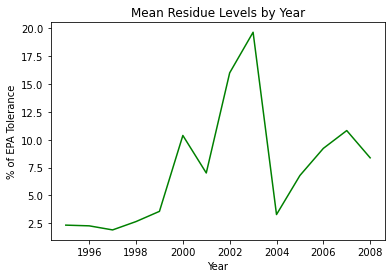

In [26]:
# Create time series plot of mean residue levels by year
residue_by_year = df.groupby('Year')['Percent of Threshold'].mean()
plt.plot(residue_by_year.index, residue_by_year.values,color='green')
plt.title('Mean Residue Levels by Year')
plt.xlabel('Year')
plt.ylabel('% of EPA Tolerance')

We can see that the percentage was quite low in the late 90's, at only 2.5-4% of the EPA Tolerance on average. This began to steadily increase after 1998 and kept increasing until about 2003 when the average was close to 20%. After this it sharply declined to base levels and began to gradually increase after that.

In order to save the figure as an image we can use the code below to save as a png in the source file location.

In [27]:
plt.savefig('mean_residue_by_year.png')

<Figure size 432x288 with 0 Axes>